In [51]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# ok biolerplate done, now we get to the action:

In [6]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item() # Checks if all elements are the same. ex is a boolean
  app = torch.allclose(dt, t.grad) # Approximately equal due to floating point arithmetic
  maxdiff = (dt - t.grad).abs().max().item() #Highest difference
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [7]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1 # using b1 just for fun, it's useless because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [8]:

batch_size = 32
n = batch_size # a shorter variable also, for convenience
# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

In [9]:
# forward pass, "chunkated" into smaller steps that are possible to backward one at a time

emb = C[Xb] # embed the characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation
# BatchNorm layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True) # Find mew
bndiff = hprebn - bnmeani # x- mew 
bndiff2 = bndiff**2  # (x - mew)**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n) # Variance, sigma squared
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-linearity
h = torch.tanh(hpreact) # hidden layer
# Linear layer 2
logits = h @ W2 + b2 # output layer

# cross entropy loss (same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability, bcuz vv high logits can cause .exp() to give inf rmb?
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, hpreact, bnraw,
         bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani,
         embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3442, grad_fn=<NegBackward0>)

Bessel's correction : Unbiased estimate 1/(n-1).

We learn in school that when we are learning from batches instead of the whole population we divded by n-1, since when learnign from batches, we almost always underestimate the variance.

In [10]:
Yb
#Yb.shape

tensor([ 8, 14, 15, 22,  0, 19,  9, 14,  5,  1, 20,  3,  8, 14, 12,  0, 11,  0,
        26,  9, 25,  0,  1,  1,  7, 18,  9,  3,  5,  9,  0, 18])

In [11]:
logprobs.shape
# We are plucking out 8 from 1st row, 14 from 2nd row, and so on...

torch.Size([32, 27])

In [12]:
logprobs[range(n), Yb]

tensor([-3.9245, -3.0769, -3.7317, -3.2031, -4.1305, -3.5683, -3.1179, -4.0072,
        -3.1981, -4.3132, -3.1671, -1.6871, -2.7952, -3.0317, -3.0178, -3.1254,
        -3.9029, -3.0216, -3.5290, -3.4031, -2.8970, -3.0021, -4.3013, -4.0711,
        -3.4528, -2.8629, -3.0094, -3.8753, -2.7998, -3.4382, -3.2455, -3.1063],
       grad_fn=<IndexBackward0>)

In [13]:
# Explaining dlogprobs
# loss = -1/3a + -1/3b + -1/3c
# dloss/da = -1/3 , More generally, -1/n

In [14]:
# Explaining dcounts_sum_inv
# c = a * b, but with tensors:
# a[3,3] * b[3,1] --->
# a11*b1 a12*b1 a13*b1
# a21*b2 a22*b2 a23*b2
# a31*b3 a32*b3 a33*b3
#c[3x3]

#Finding gradient of b(dcounts_sum_inv) is a, but since b is used multiple times across each row, we have to find the sum of 
#gradients of b across each row.

In [15]:
# Explaining dcounts 
# a11 a12 a13   ---> b1 (= a11 + a12 + a13)
# a21 a22 a23   ---> b2 (= a21 + a22 + a23)
# a31 a32 a33   ---> b3 (= a31 + a32 + a33)

# any changes to any a element is correspondingly updated to its b element by a factor of 1. No "powering up/weaking" involved
# so b's gradient is just routered to all a elements

In [16]:
# Explaining dlogit_maxes
norm_logits.shape, logits.shape, logit_maxes.shape
#similar to dcounts_sum_inv,

# c11 c12 c13 = a11 a12 a13     b1
# c21 c22 c23 = a21 a22 a23  -  b2
# c31 c32 c33 = a31 a32 a33     b3

#so e.g. c32 = a32 - b3 , the derivative of c to its corresponding elements : for a is 1, but b is -1 . So grad of c will flow
# accordingly to a's and b's , but in addition to that since b is broadcasted, we have to do the sum as well.

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32, 1]))

In [17]:
# Explaining dlogits
# logits.max(1) gives both positions and values of the max, logits.max(1).indices gives the positions 
# plt.imshow(F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]))
# Then when we * dlogit_maxes, we route the gradient to only the [1]s
# Note that the local derivative is just 1, hence we could use one_hot encoding too!

In [ ]:
# Explaining logits = h @ W2 + b2
# Time stamp 46:15
# Can use the hacky way of just looking at what shape tensor you need
# Note that @ is not * , @ is dot product 

In [ ]:
# Explaining dbndiff2
# a11 a12
# a21 a22
# --->(sum along column gives) b1   b2, where:
# b1 = 1/(n-1) * (a11 + a21)
# b2 = 1/(n-1) * (a12 + a22)

# The gradients of row vector b, has to be backpropagated along the respective COLUMNs of a

In [45]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# --------------------
# YOUR CODE HERE :)
# --------------------

dlogprobs = torch.zeros_like(logprobs) # creates an array exactly in the shape of logprobs
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

dprobs = (1.0 / probs) * dlogprobs # d/dx(logx) = 1/x , and Chain Rule
# From this you can see that if the answer character has low probability, dprobs increases, which increases lose, "boosting their gradient"
cmp('probs', dprobs, probs)

dcounts_sum_inv = (dprobs * counts).sum(1, keepdim=True) # keepdim so we get shape [32 , 1] instead of [32] only
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
# counts.shape, counts_sum_inv.shape # BEcareful, torch actually does 27 duplication horizontally to do multiplication here
# So you need to sum along dimension 1 (horizontally)(basically for all the times that it is used)

dcounts = counts_sum_inv * dprobs # counts is used twice in calculations! so we cant compare just yet
dcounts_sum = -(1/counts_sum**2) * dcounts_sum_inv # d/dx(x**-1) = -1/x**-2 , and Chain Rule
cmp('counts_sum', dcounts_sum, counts_sum) 

dcounts += torch.ones_like(counts) * dcounts_sum
# ones as operator was addition so gradient just flows as per norm
cmp('counts', dcounts, counts)

dnorm_logits = norm_logits.exp() * dcounts # d/dx(e**x) = e**x, and Chain Rule
cmp('norm_logits', dnorm_logits, norm_logits)

dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
cmp('logit_maxes', dlogit_maxes, logit_maxes)

dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
cmp('logits', dlogits, logits)

dh = dlogits @ W2.T # .T means transpose
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

db2 = dlogits.sum(0)
cmp('b2', db2, b2)

dhpreact = (1.0 - h**2) * dh # d/dx of tanh(x) is 1 - (tanh(x))**2
cmp('hpreact', dhpreact, hpreact)

dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
cmp('bngain', dbngain, bngain)

dbnbias = dhpreact.sum(0, keepdim=True)
cmp('bnbias', dbnbias, bnbias)

dbnraw = bngain * dhpreact
cmp('bnraw', dbnraw, bnraw)

dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True) # Rmb dim 0 : collapse(updown), dim 1: slap(leftright)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)

dbndiff = bnvar_inv * dbnraw # bndiff i used twice (in 2 branches)

dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
cmp('bnvar', dbnvar, bnvar)

dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar # [32,64] * [1,64], letting broadcasting help us
cmp('bndiff2', dbndiff2, bndiff2)

dbndiff += 2 * bndiff * dbndiff2 
cmp('bndiff', dbndiff, bndiff)

dbnmeani = -1 * dbndiff.sum(0, keepdim=True)
cmp('bnmeani', dbnmeani, bnmeani)

dhprebn = dbndiff
dhprebn += (1.0/n)*torch.ones_like(dhprebn) * dbnmeani # Similar to dbndiff2
cmp('hprebn', dhprebn, hprebn)

dembcat = dhprebn @ W1.T
cmp('embcat', dembcat, embcat)

dW1 = embcat.T @ dhprebn
cmp('W1', dW1, W1)

db1 = dhprebn.sum(0)
cmp('b1', db1, b1)

demb = dembcat.view(emb.shape) # Just viewing it as the original shape
cmp('emb', demb, emb)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j] # iterate through all elements
        dC[ix] += demb[k,j] # += because the same row from C could have been used many times
        # demb[k,j] contains a row of 10 vectors!
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [46]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.344177722930908 diff: 0.0


In [50]:
# backward pass
#Shortening backward pass through differentiating the mathematical form of .cross_entropy

# --------------------
# YOUR CODE HERE :)
# --------------------

# backward pass

dlogits = F.softmax(logits, 1) # since after differentiating the gradient of the logit is itself after softmax(Pi)?
dlogits[range(n), Yb] -= 1 # only difference is the correct ans is Pi - 1 
dlogits /= n # Rmb that loss is the average loss occured from each example in the batch

cmp('logits', dlogits, logits) # I can only get approximate to be true, my maxdiff is 6e-9

logits          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09


In [48]:
logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [49]:
F.softmax(logits, 1)[0]

tensor([0.0665, 0.0911, 0.0185, 0.0504, 0.0180, 0.0770, 0.0276, 0.0362, 0.0198,
        0.0295, 0.0366, 0.0361, 0.0392, 0.0304, 0.0359, 0.0127, 0.0096, 0.0212,
        0.0164, 0.0573, 0.0456, 0.0218, 0.0293, 0.0685, 0.0574, 0.0260, 0.0215],
       grad_fn=<SelectBackward0>)

In [52]:
dlogits[0] * n
# Note that the correct ans has -1

tensor([ 0.0665,  0.0911,  0.0185,  0.0504,  0.0180,  0.0770,  0.0276,  0.0362,
        -0.9802,  0.0295,  0.0366,  0.0361,  0.0392,  0.0304,  0.0359,  0.0127,
         0.0096,  0.0212,  0.0164,  0.0573,  0.0456,  0.0218,  0.0293,  0.0685,
         0.0574,  0.0260,  0.0215], grad_fn=<MulBackward0>)

In [53]:
dlogits[0].sum() #(approximately 0)
# This shows that the amount we pull up on probabilities is equal to the amount we pull down on the probabilities

# For example, if our model is trained perfectly, where all wrong ans is 0, and correct ans prob is exactly 1, we will then -1 from 
# the correct char, and have a full row of 0 gradients. p.data += -lr * p.grad , so there is no update needed which is correct!

tensor(2.3283e-10, grad_fn=<SumBackward0>)

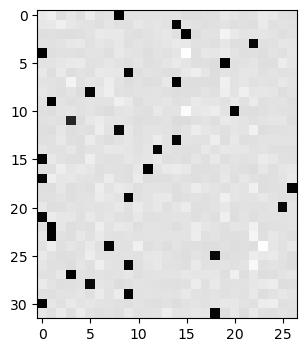

In [54]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')
# Batch of 32 examples for vocab size of 27 chars
# So what exactly is dlogits? (besides the fact that we know they are the derivative of logits)
# We are pulling down the probabilities of wrong chars, and pulling up the probabilities of the correct char in each row

In [55]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# Note : hprebn : stands for hidden states for the pre batch normalization
# hpreact : stands for hidden states pre activation

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [56]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10


In [57]:
dhprebn.shape, bngain.shape, bnvar_inv.shape, dbnraw.shape, dbnraw.sum(0).shape

(torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([32, 64]),
 torch.Size([64]))

In [58]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

  # kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None
    #loss.backward() # use this for correctness comparisons, delete it later!

    # manual backprop! #swole_doge_meme
    # -----------------
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # tanh
    dhpreact = (1.0 - h**2) * dh
    # batchnorm backprop
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    # 1st layer
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(emb.shape)
    dC = torch.zeros_like(C)
    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]
    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

  #   if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #     break

12297
      0/ 200000: 3.7877
  10000/ 200000: 2.2073
  20000/ 200000: 2.4043
  30000/ 200000: 2.4325
  40000/ 200000: 1.9854
  50000/ 200000: 2.3670
  60000/ 200000: 2.3711
  70000/ 200000: 2.0145
  80000/ 200000: 2.4182
  90000/ 200000: 2.1334
 100000/ 200000: 1.9815
 110000/ 200000: 2.3496
 120000/ 200000: 2.0274
 130000/ 200000: 2.4323
 140000/ 200000: 2.3031
 150000/ 200000: 2.2187
 160000/ 200000: 1.9385
 170000/ 200000: 1.8903
 180000/ 200000: 2.0422
 190000/ 200000: 1.9102


In [59]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [60]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [61]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.072087049484253
val 2.108250617980957


In [62]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mora.
mayah.
seel.
ndheyah.
reisantengraege.
zered.
elin.
shi.
jen.
eden.
estanaraelyn.
malaia.
noshubergiagriel.
kindreelynn.
novana.
ububred.
ryyah.
fael.
yuma.
myston.
